In [1]:
import os,glob
import pandas as pd
import numpy as np
import cooler
import seaborn as sns
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import  pyplot as plt

from hicool.Module import AutoLoad


# 1.数据预处理，合并为scool和meta信息文件

## 1.1 使用进程池包装txt2cool函数，定义全局变量以及可变参数

In [3]:
from hicool.Module.transform import txt2scool
prefix = "test"
chroms = [1,3]
positions = [2,4]
resolution = 100000
file_list = glob.glob("../data/Test/*contacts.pairs.txt.gz")
chromsizes = "../data/mm10.chrom.sizes.txt"
chrom_list = ["chr1","chr2","chr3","chr4","chr5",
          "chr6","chr7","chr8","chr9","chr10",
          "chr11","chr12","chr13","chr14","chr15",
          "chr16","chr17","chr18","chr19","chrX"]
save_dir = "../data/results"
scool_path = txt2scool(file_path=file_list,chrom_list=chrom_list,chromsizes=chromsizes,prefix=prefix,resolution=resolution,save_dir=save_dir)


 Start processing files ...


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 Creating ../data/results/test_100000.scool finished , including 20 single cells with resolution 100000. 
 Totally take 7.895798444747925 seconds.


### 1.2 读取单细胞txt矩阵和信息，生成scool和pickle文件

In [20]:
runtable_path = "../data/GSE121791RunTable.txt"
RunTable = pd.read_csv(runtable_path).drop_duplicates("Sample Name")
label = pd.DataFrame(columns = ["path"],data = file_list)
label["Sample Name"] = label["path"].apply(lambda x : os.path.basename(x).split("_")[0])
label = pd.merge(label,RunTable).set_index("Sample Name")
label.to_pickle("../data/Dip-C2019.pickle")

### 1.3 读取scool格式文件和pickle信息

In [17]:
scool = AutoLoad(scool_path)
cell_list = scool.load_scool_cells()
cell_list[:5]

['/store/zlwang/Workspace/Myproject/hicool/data/results/test_100000.scool::/cells/GSM3588984_cell_146',
 '/store/zlwang/Workspace/Myproject/hicool/data/results/test_100000.scool::/cells/GSM3589011_cell_173',
 '/store/zlwang/Workspace/Myproject/hicool/data/results/test_100000.scool::/cells/GSM3589022_cell_184',
 '/store/zlwang/Workspace/Myproject/hicool/data/results/test_100000.scool::/cells/GSM3589035_cell_197',
 '/store/zlwang/Workspace/Myproject/hicool/data/results/test_100000.scool::/cells/GSM3589041_cell_203']

In [15]:
cell_type = pd.read_pickle("../data/Dip-C2019.pickle")["Cell_type"]
cell_type[:5]

Sample Name
GSM3588984                       retina
GSM3589011                       retina
GSM3589022                       retina
GSM3589035    main olfactory epithelium
GSM3589041    main olfactory epithelium
Name: Cell_type, dtype: object

In [22]:
label_colname = "Cell_type"
save_dir = "../data/results"
RunTable = pd.read_csv(runtable_path).drop_duplicates("Sample Name")
label = pd.DataFrame(columns = ["RawPath"],data = file_list)
label["Sample Name"] = label["RawPath"].apply(lambda x : os.path.basename(x).split("_")[0])
meta = pd.merge(label,RunTable)
meta = meta[['RawPath',"Sample Name",label_colname]]
meta_path = save_dir + "/" + prefix + "_raw_meta.csv"
meta.to_csv(meta_path,index=0)

In [23]:
meta[:5]

,RawPath,Sample Name,Cell_type
0,../data/Test/GSM3588984_cell_146.contacts.pair...,GSM3588984,retina
1,../data/Test/GSM3589011_cell_173.contacts.pair...,GSM3589011,retina
2,../data/Test/GSM3589022_cell_184.contacts.pair...,GSM3589022,retina
3,../data/Test/GSM3589035_cell_197.contacts.pair...,GSM3589035,main olfactory epithelium
4,../data/Test/GSM3589041_cell_203.contacts.pair...,GSM3589041,main olfactory epithelium


### 1.4 绘制统计信息

test_100000 loaded, including 20 single cells with resolution 100000. 


100%|██████████| 20/20 [00:00<00:00, 29.62it/s]


17 passed quality control, with more than 10000 contacts, more than 10000 nonzero bins , intra contacts percentage more than 50.0 %.
Saving quality control figures results to /store/zlwang/Workspace/Myproject/hicool/data/results/test_100000_qc.png
Saving quality control cells results to /store/zlwang/Workspace/Myproject/hicool/data/results/test_100000_qc_meta.csv


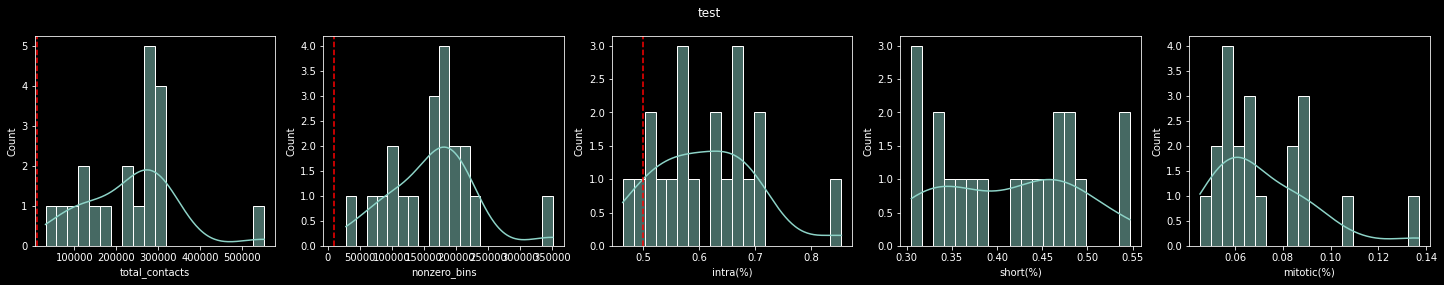

In [26]:
from hicool.Module import quality_control
meta_pass = quality_control(scool_path,meta_path)



Saving quality controlled cells stats to /store/zlwang/Workspace/Myproject/hicool/data/results/test_100000_qc_meta.csv


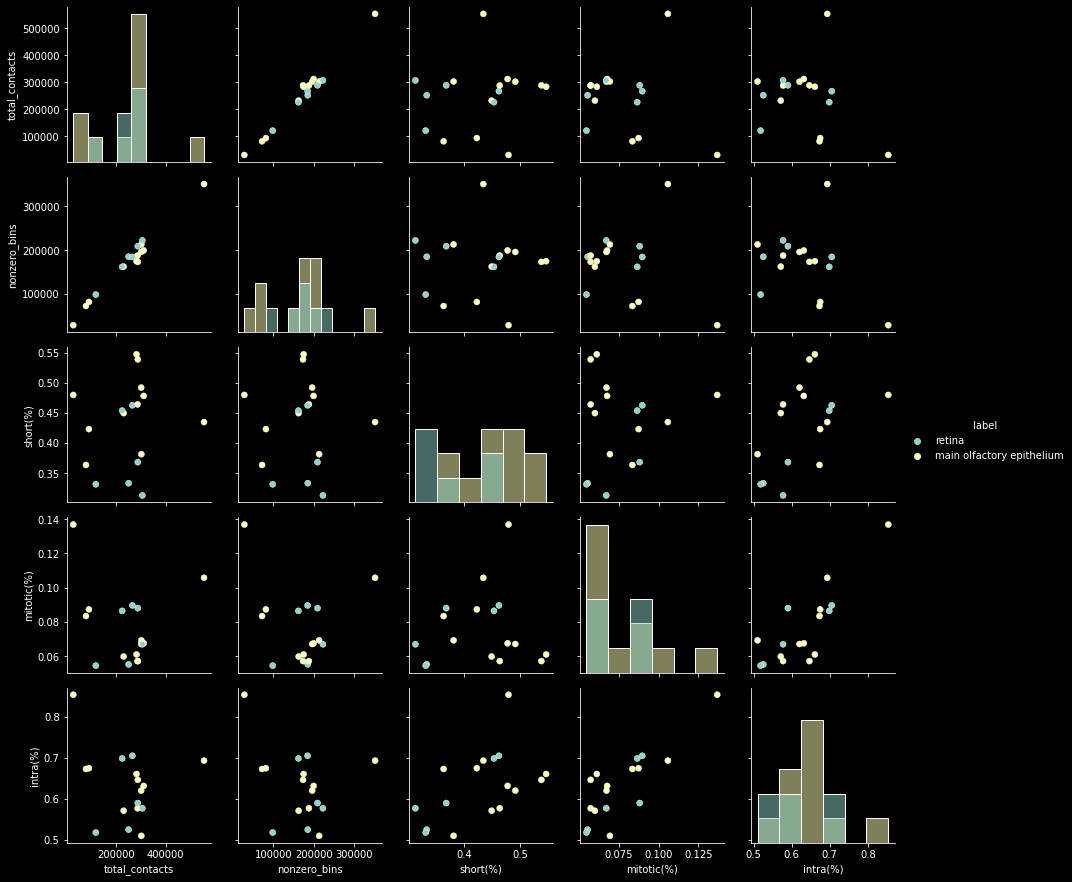

In [29]:
from hicool.Module import plot_stats
plot_stats(meta_pass)

## 1.6 将邻接矩阵归一化，转化为numpy向量（张量） 

In [129]:
scool_qc = Auto_load("Dip-C2019_1000000_qc.scool")
cell_list,bins,pixel_list = scool_qc.load_scool()
meta = pd.read_pickle("Dip-C2019_qc.pickle")


Dip-C2019_1000000_qc loaded, including 236 single cells with resolution 1000000. 


In [130]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
def oe(matrix, expected = None):
    new_matrix = np.zeros_like(matrix)
    matrix =  np.array(matrix).astype('float32')
    for k in range(len(matrix)):
        rows, cols = kth_diag_indices(matrix, k)
        diag = np.diag(matrix,k)
        if expected is not None:
            expect = expected[k]
        else:
            expect = np.nanmean(diag)
        if expect == 0:
            new_matrix[rows, cols] = 0.0
        else:
            new_matrix[rows, cols] = diag / (expect+1e-15)
    new_matrix = new_matrix + new_matrix.T
    return new_matrix

def min_max_norm(mat):
    mat = (mat - mat.min())/(mat.max()-mat.min())
    return mat
def log_norm(mat):
    mat = np.log(mat+1)
    return mat

In [265]:
def get_matrix(cell,chrom='chr1'):
    matrix = cooler.Cooler(cell).matrix(balance=False).fetch(chrom)[:]
    matrix = log_norm(oe(matrix))   
    return matrix

In [266]:
chr1 = []
for cell in cell_list:
    chr1.append(get_matrix(cell))

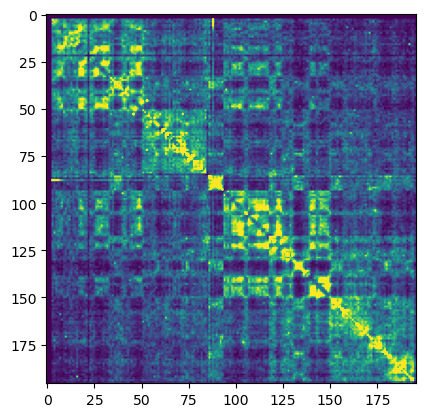

In [277]:
plt.imshow(np.array(chr1).mean(axis = 0), vmin = 0 ,vmax = 0.5)


In [268]:
meta = pd.read_pickle("Dip-C2019_qc.pickle")
chr1 = np.array(chr1)
chr1_retina = chr1[(meta.Cell_type == "retina").values]
chr1_MOE = chr1[(meta.Cell_type == "main olfactory epithelium").values]


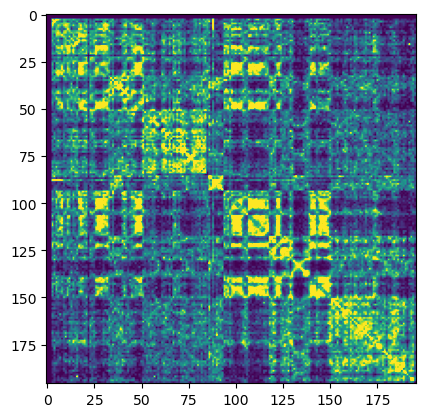

In [275]:
plt.imshow(chr1_retina.mean(axis = 0), vmin = 0 ,vmax = 0.5)


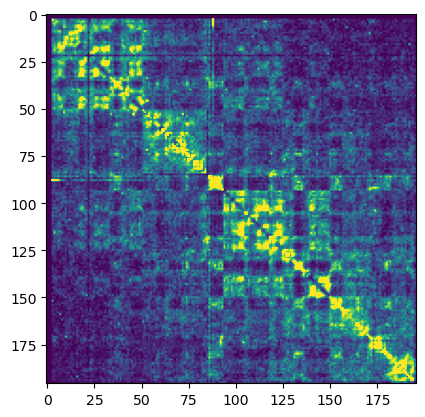

In [276]:
plt.imshow(chr1_MOE.mean(axis = 0), vmin = 0 ,vmax = 0.5)


/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


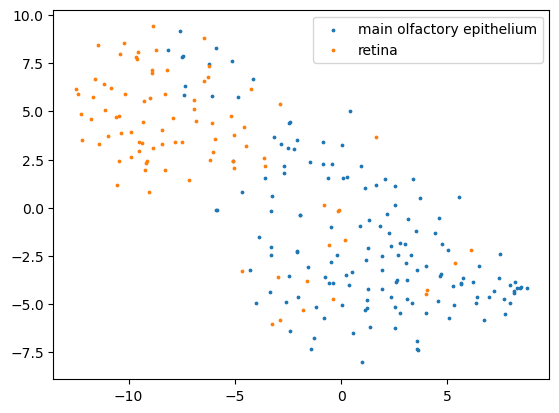

In [335]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE().fit_transform(chr1.sum(axis = 1))
scatter(tsne,label = meta.Cell_type.values)

In [324]:
chr1_node_degree = chr1.sum(axis = 1)

In [330]:
chr1_r10 = chr1_node_degree.repeat(10,axis = 1)

In [333]:
chr1_r10[1][100:120]

array([18.80967495, 18.80967495, 18.80967495, 18.80967495, 18.80967495,
       18.80967495, 18.80967495, 18.80967495, 18.80967495, 18.80967495,
       42.3699602 , 42.3699602 , 42.3699602 , 42.3699602 , 42.3699602 ,
       42.3699602 , 42.3699602 , 42.3699602 , 42.3699602 , 42.3699602 ])

In [139]:
chr1.sum(axis = 1).shape

(236, 196)

/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


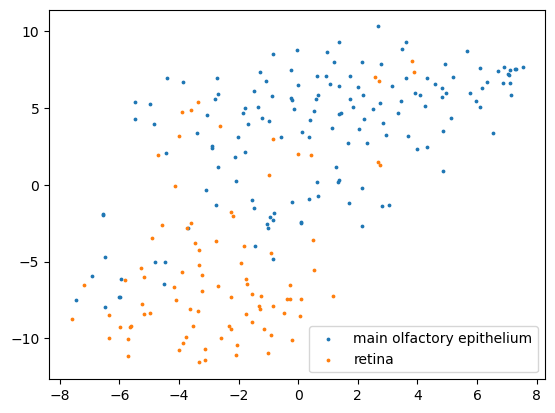

In [334]:
tsne = TSNE().fit_transform(chr1_r10)
scatter(tsne,label = meta.Cell_type.values)

In [102]:
from schictools3.utils import scatter

In [81]:
chr1_retina.sum(axis = 1)

array([[ 0.        ,  0.        ,  0.        , ..., 53.08098001,
        90.05162979, 30.04894379],
       [ 0.        ,  0.        ,  0.        , ..., 53.73584341,
        34.06562536, 15.54942903],
       [ 0.        ,  0.        ,  0.        , ..., 13.94126176,
        23.68899735, 13.58458682],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 29.92456656,
        42.63142261, 24.14206022],
       [ 0.        ,  0.        ,  0.        , ..., 12.01823591,
         8.61613314,  5.63121178],
       [ 0.        ,  0.        ,  0.        , ..., 45.80198315,
        21.3347077 ,  9.06693179]])

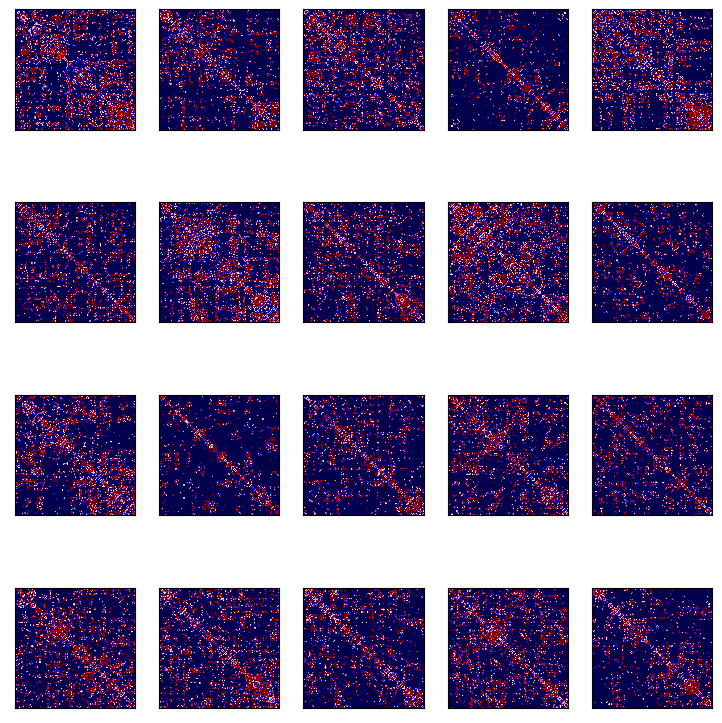

In [280]:
def plot_gallery(images, titles,n_row=4, n_col=5,cmap = False, method = plt.imshow ):
    """Helper function to plot a gallery of figures in certain method """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    #plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if cmap == False:
            method(images[i])
        else :
            method(images[i],cmap = cmap,vmax = 0.5)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(chr1_retina[:25],[None]*25,cmap = "seismic")

In [ ]:
plot_gallery(ccc1[:25],[None]*25,cmap = "seismic")

In [313]:
chr11 = np.concatenate([chr1_retina,chr1_MOE]).astype("float32")

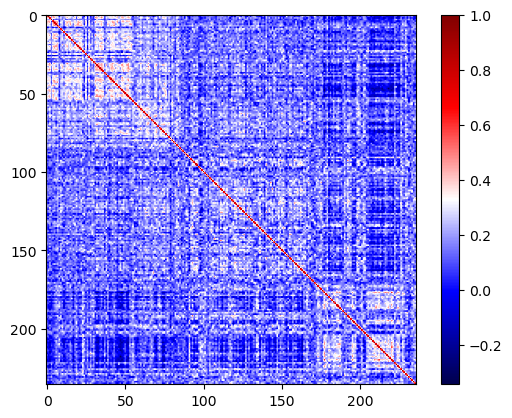

In [307]:
plt.imshow(np.corrcoef(chr11.sum(axis = 1)),cmap="seismic")
plt.colorbar()

In [318]:
np.save("/store/zlwang/Workspace/code/graph/GCN-GAN/GCN-GAN-pytorch-master/data/hic/train.npy",chr11[:202])

In [319]:
np.save("/store/zlwang/Workspace/code/graph/GCN-GAN/GCN-GAN-pytorch-master/data/hic/test.npy",chr11[202:])
chr11[1].dtype

dtype('float32')

In [290]:
ccc1 = np.load("/store/zlwang/Workspace/code/graph/GCN-GAN/GCN-GAN-pytorch-master/data/UCSB/train.npy")

In [300]:
ccc1[1]

array([[0.        , 0.        , 0.00021701, ..., 0.        , 0.        ,
        0.00085722],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00021701, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00218412],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00085722, 0.        , 0.00218412, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

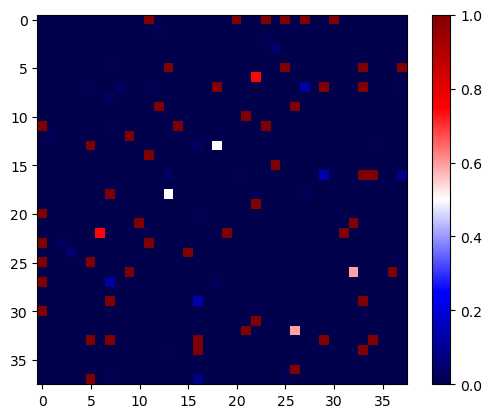

In [292]:
plt.imshow(ccc1[1],cmap="seismic")
plt.colorbar()


In [82]:
min_max_norm(oe(matrix))

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02083333, 0.03125   ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03125   , 0.02083333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [69]:
import networkx as nx
from node2vec import Node2Vec
# Create a graph
graph = nx.fast_gnp_random_graph(n = 100, p = 0.5)
# Precompute probabilities and generate walks
node2vec = Node2Vec(graph, dimensions = 1, walk_length = 30, num_walks = 200,p = 0.3, q = 0.7,workers = 1)#dimensions = 64,
# Embed nodes
model = node2vec.fit(window = 20, min_count = 1, batch_words = 4)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████| 200/200 [00:03<00:00, 54.40it/s]


In [200]:
def cal_node2vec(cell):
    G = nx.from_numpy_matrix(get_matrix(cell))
    node2v = Node2Vec(G, dimensions = 32,p = 0.3, q = 0.7,workers = 1,seed= seed)
    model = node2v.fit(window = 10, min_count = 1, batch_words = 4)
    nodefeature = model.wv.vectors.reshape((1,-1))
    return nodefeature


In [236]:
G.graph

{}

In [231]:
node2v = Node2Vec(G, dimensions = 32,p = 0.3, q = 0.7,workers = 1,seed= seed)
model = node2v.fit(window = 10, min_count = 1, batch_words = 4)



Computing transition probabilities:   0%|          | 0/196 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████| 10/10 [00:00<00:00, 14.95it/s]


In [ ]:
nodefeatures = []
for cell in cell_list:
    nf = cal_node2vec(cell)
    nodefeatures.append(nf)

In [ ]:
import random
seed = random.randint(1, 10000)
random.seed(seed)
print(seed)
with Pool(processes = 10) as pool:
    result = list(tqdm(pool.imap(cal_node2vec,cell_list), total= len(cell_list)))

In [174]:
nodef = np.array(nodefeatures).reshape(len(nodefeatures),-1)
nodef

array([[-0.31144357, -0.37982088, -0.04157013, ..., -0.02423593,
        -0.02890529,  0.00735025],
       [-0.1390755 , -0.6543051 , -0.30361462, ..., -0.02423593,
        -0.02890529,  0.00735025],
       [ 0.148754  , -0.32516402,  0.11833516, ..., -0.02423593,
        -0.02890529,  0.00735025],
       ...,
       [ 0.05899984,  0.02430712, -0.2131389 , ..., -0.02423593,
        -0.02890529,  0.00735025],
       [ 0.12959413, -0.54611427,  0.32514167, ..., -0.02423593,
        -0.02890529,  0.00735025],
       [-0.15563524, -0.3743515 ,  0.19522004, ..., -0.02423593,
        -0.02890529,  0.00735025]], dtype=float32)

In [203]:
cal_node2vec(cell_list[0])

Computing transition probabilities:   0%|          | 0/196 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████| 10/10 [00:00<00:00, 12.53it/s]


array([[ 0.07142091, -0.12233411,  0.12495071, ..., -0.02423593,
        -0.02890529,  0.00735025]], dtype=float32)

In [206]:
cal_node2vec(cell_list[1])

Computing transition probabilities:   0%|          | 0/196 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████| 10/10 [00:00<00:00, 15.19it/s]


array([[ 0.13907318,  0.05883839,  0.47389507, ..., -0.02423593,
        -0.02890529,  0.00735025]], dtype=float32)

<AxesSubplot:>

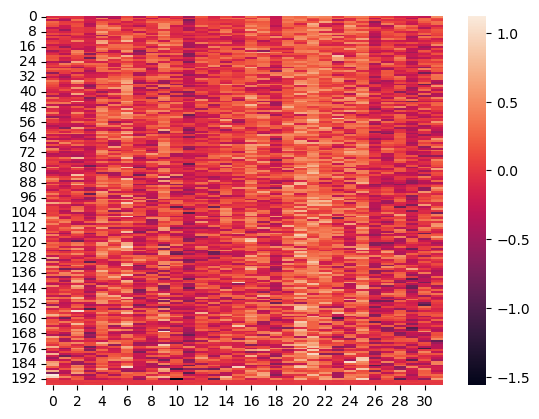

In [233]:
w = model.wv.vectors
sns.heatmap(model.wv.vectors)

In [221]:
w.shape

(2645, 32)

<AxesSubplot:>

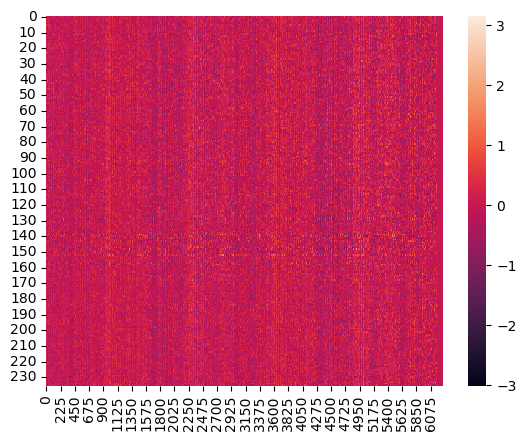

In [211]:
sns.heatmap(nd)

/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/store/zlwang/anaconda3/envs/higashi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


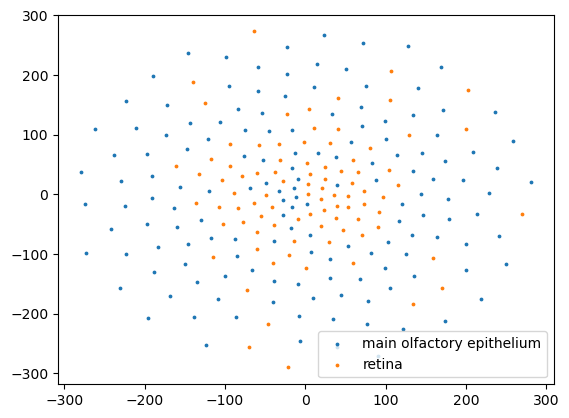

In [208]:
nd = np.array(result).reshape(len(result),-1)
tsne = TSNE(2).fit_transform(nd)
scatter(tsne,label = meta.Cell_type.values)

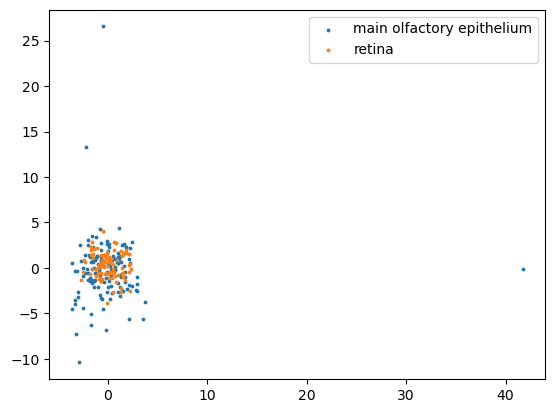

In [171]:
tsne = PCA(2).fit_transform(nodef)
scatter(tsne,label = meta.Cell_type.values)

<AxesSubplot:>

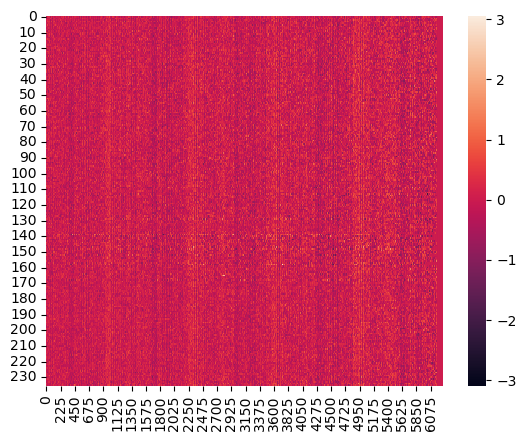

In [173]:
sns.heatmap(nodef)